In [69]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [70]:
#importing the necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [71]:
#reading the CSV file
x = pd.read_csv("sms-spam.csv")

#displaying the dataframe
x

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [72]:
#dataset size - 5572 rows x 5 columns
x.shape

(5572, 5)

## Data Cleaning

In [73]:
#printing the concise summary of the dataset
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [74]:
#column 2, 3, 4 have majority missing values, so it is better to drop them.
x.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

#displaying the edited dataframe
x

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [75]:
#renaming the column names to a better and meaningful column name
x.rename(columns = {'v1':'result', 'v2':'input'}, inplace=True)

#displaying the edited dataframe
x

,result,input
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [76]:
#result has categorical labels, we need to convert it into numerical values - enbcoding
#for that we will be using 'LabelEncoder' from sklearn

In [77]:
encoder = LabelEncoder()
x['result'] = encoder.fit_transform(x['result'])

#displaying the edited dataframe
x.head()

,result,input
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [78]:
#so 0 means no SPAM, 1 means SPAM

In [79]:
#check if there is any NULL value
x.isnull().sum()

result    0
input     0
dtype: int64

In [80]:
#the dataset has NO null values, so don't need to handle them

In [81]:
#check if there is any DUPLICATE values
x.duplicated().sum()

np.int64(403)

In [82]:
#the dataset has DUPLICATE values, so we will have to REMOVE them
x = x.drop_duplicates(keep='first')

#displaying the edited dataframe
x

,result,input
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [83]:
#rows reduced from 5572 to 5169 after DUPLICATED values have been deleted

## EDA - Exploratory Data Analysis

In [84]:
#the given problem is a classification problem, so we need to understand the data first by performing EDA.
#the dataset has only 2 columns, so less analysis required.

In [85]:
#checking the number of SPAM vs not SPAM messages
x['result'].value_counts()

result
0    4516
1     653
Name: count, dtype: int64

In [86]:
#out of 5169 datavalues, 653 are SPAM

In [87]:
653*100.0/5169

12.633004449603405

In [88]:
#12.63% is SPAM and 87.37% is not SPAM

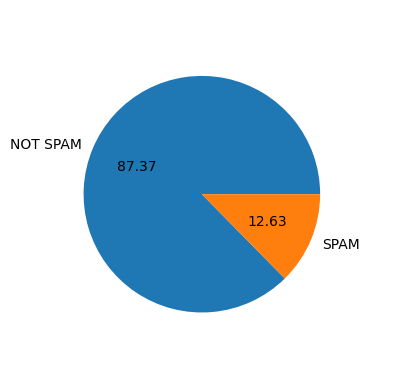

In [89]:
#for better representation, we can use PIE CHART to represent it.
#PIE CHARTS can be created using matplotlib library

plt.pie(x['result'].value_counts(),  labels = ['NOT SPAM', 'SPAM'], autopct = '%0.2f', radius = 0.8)
plt.show()

In [90]:
#hence, highly IMBALANCED DATA

In [91]:
#now we will be analysing the number of alphabets/words/sentences being used in the TEXT
#for this, will create 3 new columns: (1) no. of characters (2) no. of words (3) no. of sentences in SMS

#using 'nltk' library for this. 
#Natural Language Toolkit for text processing 
#(pip install nltk)

In [92]:
#downloading the dependencies 
#punkt package includes pre-trained models for tokenizing text in many languages

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dkpra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [93]:
#creating a new column with count of characters
x['countCharacters'] = x['input'].apply(len)

#creating a new column with count of words
x['countWords'] = x['input'].apply(lambda i:len(nltk.word_tokenize(i)))
#'word_tokenize' function takes a string of text as input and returns a list of words

#creating a new column with count of sentences
x['countSentences'] = x['input'].apply(lambda i:len(nltk.sent_tokenize(i)))
#'sent_tokenize' function takes a string of text as input and returns a list of sentences

C:\Users\dkpra\AppData\Local\Temp\ipykernel_22444\3785843795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['countCharacters'] = x['input'].apply(len)
C:\Users\dkpra\AppData\Local\Temp\ipykernel_22444\3785843795.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['countWords'] = x['input'].apply(lambda i:len(nltk.word_tokenize(i)))
C:\Users\dkpra\AppData\Local\Temp\ipykernel_22444\3785843795.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [94]:
#displaying the edited dataframe with the 3 new columns added
x.head()

,result,input,countCharacters,countWords,countSentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [95]:
#extracting the 5 number summary of the 3 new column values
x[['countCharacters', 'countWords', 'countSentences']].describe()

,countCharacters,countWords,countSentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [96]:
#extracting the same summaries, classified on the basis of SPAM and not SPAM

In [97]:
#for not SPAM
x[x['result'] == 0][['countCharacters', 'countWords', 'countSentences']].describe()

,countCharacters,countWords,countSentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [98]:
#for SPAM
x[x['result'] == 1][['countCharacters', 'countWords', 'countSentences']].describe()

,countCharacters,countWords,countSentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='countCharacters', ylabel='Count'>

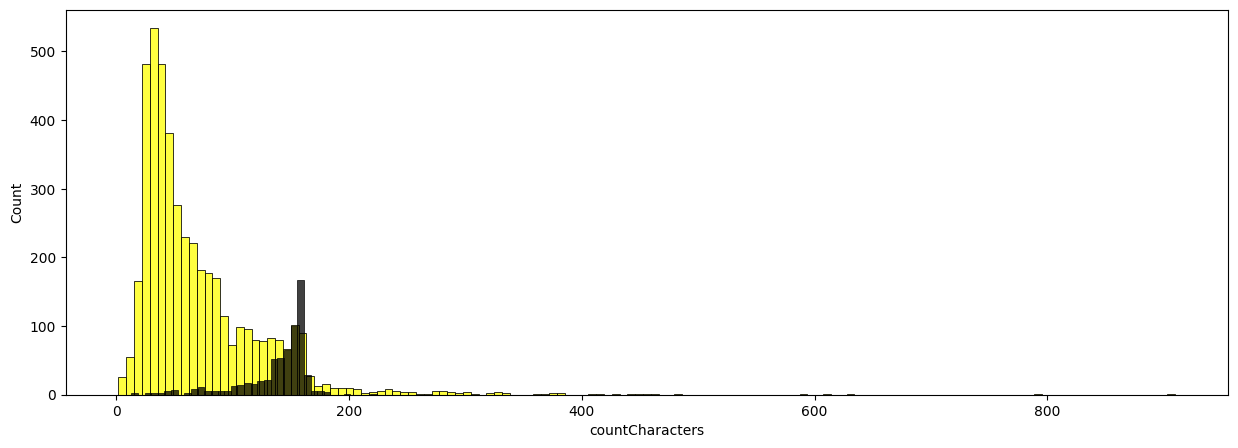

In [99]:
#for better visualization, we will plot a histogram using 'seaborn'
plt.figure(figsize = (15, 5))
sns.histplot(x[x['result'] == 0]['countCharacters'], color = "yellow")
sns.histplot(x[x['result'] == 1]['countCharacters'], color = "black")

#black -> SPAM, yellow -> not SPAM

<Axes: xlabel='countWords', ylabel='Count'>

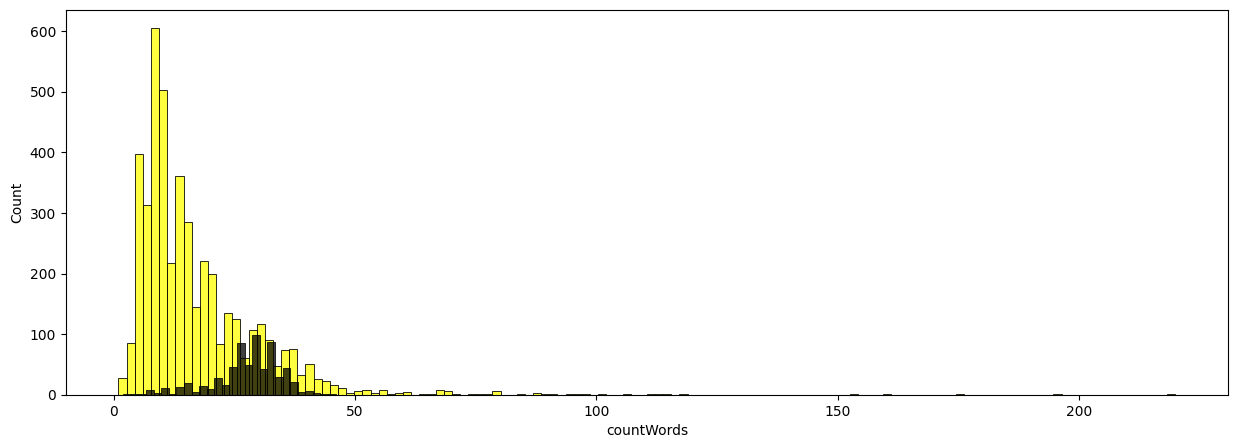

In [100]:
plt.figure(figsize = (15, 5))
sns.histplot(x[x['result'] == 0]['countWords'], color = "yellow")
sns.histplot(x[x['result'] == 1]['countWords'], color = "black")

#black -> SPAM, yellow -> not SPAM

In [101]:
#observation : SPAM messages have more no of characters used, mean is 137.89 for SPAM and 70.45 for not SPAM

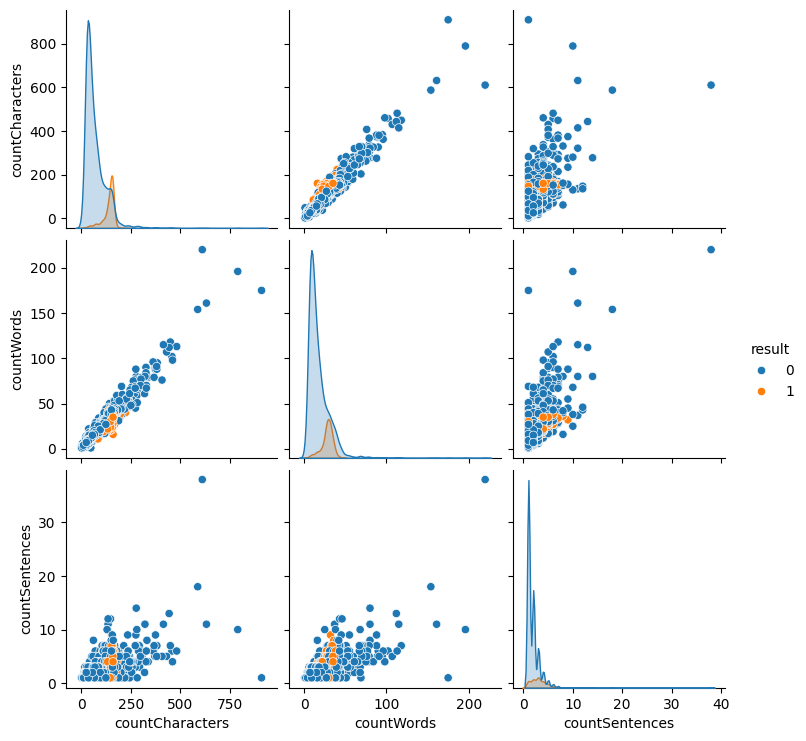

In [102]:
#finding relationship between the columns
sns.pairplot(x, hue='result')

## Data Preprocessing

In [103]:
#peforming preprocessing such as tokenization (converting the text into tokens or words), removing special characters,
#removing stop words and punctuation and finallying stemming the data.
#also, converting to lower case first and then pre-processing the data

In [104]:
#downloading the package which contains the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dkpra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [105]:
def transform_text (text):
    
    #converting to lower case
    text = text.lower()
    
    #tokenization
    text = nltk.word_tokenize(text)
    
    #removing special characters
    removedSC = list()
    for i in text:
        if i.isalnum():
            removedSC.append(i)
            
    #updating the text after removed special characters
    text = removedSC[:]
    
    #removing stop words and punctuation characters
    removedSWPC = list()
    for i in text:
        #stopwords.words('english') is a function of 'nltk', returns list of english stop words
        #string.punctuation is a part of 'string' module, containing the ASCII punctuation characters
        if i not in stopwords.words('english') and i not in string.punctuation:
            removedSWPC.append(i)
            
    #updating the text after removed stop words and punctuation characters
    text = removedSWPC[:]
    
    #stemming the data using 'PorterStemmer' algorithm.
    #nltk module provides this class to use.
    ps = PorterStemmer()
    stemmed = list()
    for i in text:
        stemmed.append(ps.stem(i))
    text = stemmed[:]
    return " ".join(text)

In [106]:
#function for transforming the text is ready

In [107]:
#will create a new column to store the transformed text -> 'processed'
x['processed'] = x['input'].apply(transform_text)

#displaying the edited dataframe with a new column 'processed'
x.head()

C:\Users\dkpra\AppData\Local\Temp\ipykernel_22444\2432381459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['processed'] = x['input'].apply(transform_text)


,result,input,countCharacters,countWords,countSentences,processed
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [108]:
#will be creating word cloud for data visualization to display the most frequently occurring words in the processed dataset.
#using 'WordCloud' class

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

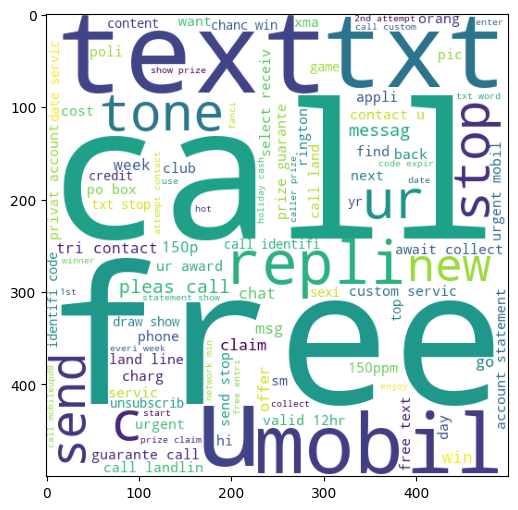

In [109]:
#creating a wordcloud for the SPAM messages
spamWC = wc.generate(x[x['result'] == 1]['processed'].str.cat(sep=" "))

#creating figure and displaying
plt.figure(figsize=(12, 6))
plt.imshow(spamWC)

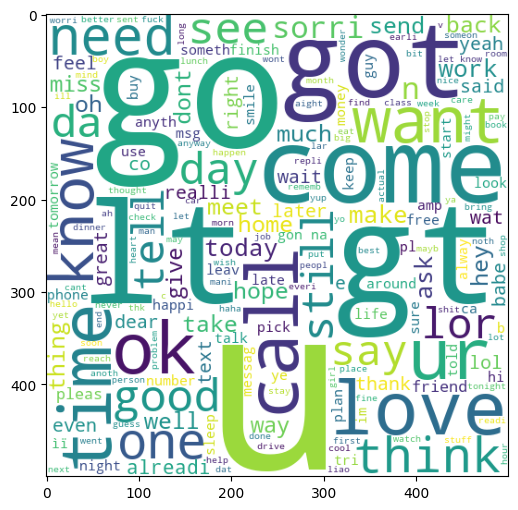

In [110]:
#creating a wordcloud for the not SPAM messages
spamWC = wc.generate(x[x['result'] == 0]['processed'].str.cat(sep=" "))

#creating figure and displaying
plt.figure(figsize=(12, 6))
plt.imshow(spamWC)

In [111]:
#extracting the most common words used in both SPAM and not SPAM messages

In [112]:
#extracting all the words used in SPAM messages
spamWords = list()

for msg in x[x['result'] == 1]['processed'].tolist():
  for word in msg.split():
    spamWords.append(word)

spamWords

['free',
 'entri',
 '2',
 'wkli',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkt',
 '21st',
 'may',
 'text',
 'fa',
 '87121',
 'receiv',
 'entri',
 'question',
 'std',
 'txt',
 'rate',
 'c',
 'appli',
 '08452810075over18',
 'freemsg',
 'hey',
 'darl',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chg',
 'send',
 'rcv',
 'winner',
 'valu',
 'network',
 'custom',
 'select',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobil',
 '11',
 'month',
 'u',
 'r',
 'entitl',
 'updat',
 'latest',
 'colour',
 'mobil',
 'camera',
 'free',
 'call',
 'mobil',
 'updat',
 'co',
 'free',
 '08002986030',
 'six',
 'chanc',
 'win',
 'cash',
 '100',
 'pound',
 'txt',
 'csh11',
 'send',
 'cost',
 '6day',
 'tsandc',
 'appli',
 'repli',
 'hl',
 '4',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'prize',
 'jackpot',
 'txt',
 'word',
 'claim',
 '81010',
 'c',
 'lccltd',
 'pobox',
 '4403ldnw

In [113]:
#to count the frequency of the words, we will be using the Counter class to create a dictionary
spamWordsDictionary = Counter(spamWords)

#to extract the most common words
spamWordsDictionary.most_common(40)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45),
 ('custom', 42),
 ('messag', 42),
 ('guarante', 42),
 ('per', 41),
 ('chat', 38),
 ('tri', 37),
 ('msg', 35),
 ('draw', 35),
 ('number', 35),
 ('cs', 35)]

In [114]:
#converting this dictionary to a dataframe
mostCommonSPAM = pd.DataFrame(spamWordsDictionary.most_common(40))

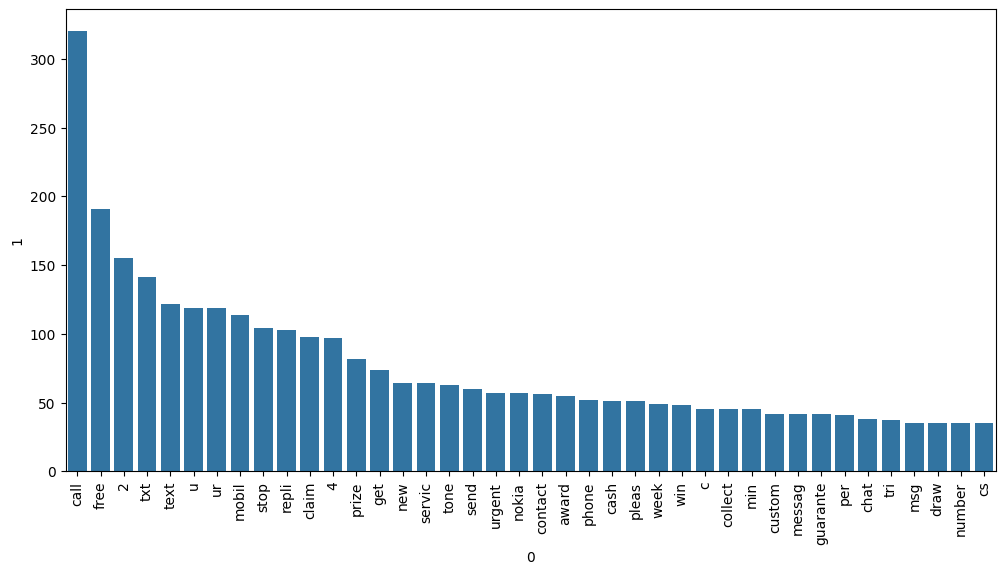

In [115]:
#plotting a bar plot of the mostCommonSPAM dataframe
plt.figure(figsize=(12, 6))
sns.barplot(data = mostCommonSPAM, x=0, y=1)
plt.xticks(rotation='vertical')
plt.show()

In [116]:
#words like 'CALL', 'FREE', '2', 'TXT', 'TEXT', 'UR', 'MOBIL' are the most common words in SPAM texts

## Model Building

In [117]:
#NaiveBayes classifier works BEST on textual data, so will firstly perform it on the dataset.

In [118]:
#we need to give numerical inputs to the classifier model, so will have to convert the 'processed' column into vectors.
#using 'bag of words'

In [119]:
#converting the collection of text into a matrix of token counts
cv = CountVectorizer()

In [120]:
#transforming the data of processed column
X = cv.fit_transform(x['processed']).toarray()

#printing size of X
X.shape

(5169, 6708)

In [121]:
#storing the values of the 'result' column
y = x['result'].values
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

In [122]:
#splitting the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 49)

In [123]:
#creating the objects for the models
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [124]:
#training the dataset for GaussianNB
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8617021276595744
[[774 125]
 [ 18 117]]
0.4834710743801653


In [125]:
#training the dataset for MultinomialnNB
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9700193423597679
[[882  17]
 [ 14 121]]
0.8768115942028986


In [126]:
#training the dataset for BernoulliNB
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9642166344294004
[[893   6]
 [ 31 104]]
0.9454545454545454


In [127]:
#we have to focus mainly on 'precision' value
#the max precision we got is 9.45 with 9.64 as accuracy

In [128]:
#using 'TfidfVectorizer' for vectorization 
tf = TfidfVectorizer()

#transforming the data of processed column
X = tf.fit_transform(x['processed']).toarray()

#storing the values of the 'result' column
y = x['result'].values

#splitting the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 49)

In [129]:
#training the dataset for GaussianNB
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8597678916827853
[[775 124]
 [ 21 114]]
0.4789915966386555


In [130]:
#training the dataset for MultinomialnNB
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9574468085106383
[[899   0]
 [ 44  91]]
1.0


In [131]:
#training the dataset for BernoulliNB
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9642166344294004
[[893   6]
 [ 31 104]]
0.9454545454545454


In [132]:
#model is PREPARED.
#now we have to host the website, for that pipeling needs to be done
#the text which we will get, has to be transformed first, then vectorized and then apply the algorithm

In [133]:
#we will pickle 2 files
import pickle
pickle.dump(tf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))